In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import scipy
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
color_back = 'lightgray'
color_front = 'mediumseagreen'
SEED=42
data_folder = '../data/'

pd.options.display.max_rows = 500
pd.options.display.max_columns = 500
pd.options.display.width = 2000
pd.options.display.max_colwidth = 2000
import tqdm

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv(data_folder + 'processed/data.csv')
country_col = 'In which country do you currently reside?'
salary_column = 'What is your current yearly compensation (approximate $USD)?'
job_title_col = 'Job title'
age_column = 'What is your age (# years)?'
experience_column = 'How long have you been writing code to analyze data (at work or at school)?'
education_column = 'What is the highest level of formal education that you have attained or plan to attain within the next 2 years?'

In [2]:
!python ../src/data/make_dataset.py

2020-05-22 21:00:02,057 - __main__ - INFO - making final data set from raw data


# Introduction

In this notebook I'm going to carry out an analysis of women community on Kaggle using statistics and social network analysis methods. The dataset comes from 2019 Kaggle ML & DS Survey, in which kagglers were asked several questions regarding their sociodemographic data, maturity of machine learning methods applied in their workplaces, and skills the kagglers have.

In particular, I will try to answer following questions:
- what is a gender ratio on Kaggle
- how gender ratio differs across countries
- how gender ratio differs across people with particular job titles
- does gender bias apply to salaries
- general sociodemographic picture of female kagglers
- how homogeneous are female kagglers, in terms of skills they have
- how connected are female kagglers' skills
- whata are the core and periphery skills of female kagglers

I've chosen this topic because I believe that data science community should be very inclusive. It's important to have diverse people onboard, to help improve ethical aspect of data science and engineering in general. There is a lot to be done, and platforms like Kaggle should be supportive in this development.

# Acknowledgement

In this analysis, I use users-skills matrix to build a biparitate graph. Based on this graph, I create users similarity graph and skills similarity graph.

Similar technique was introduced by kagglers Kate Melianova and Artem Volgin to explore phd community on Kaggle. They've used cosine similarity to measure similarity between users, based on their skillset, and to measure similarity between particular skills, based on common users that have this skill. Their analysis can be found here: https://www.kaggle.com/artvolgin/exploring-phd-community-with-network-analysis

My approach is similar to theirs, I was inspired how social network analysis can be used to visualize complex dataset, and decided to use it to analize this dataset from a different angle.

# Gender ratio

The plot indicates huge gender gap among Kaggle users. Females are a minority. There is also a very small fraction of kagglers that prefer to self-describe or not to share their Gender - there is not enough data about them, so unfortunatelly, I won't be able to include them in the analysis.

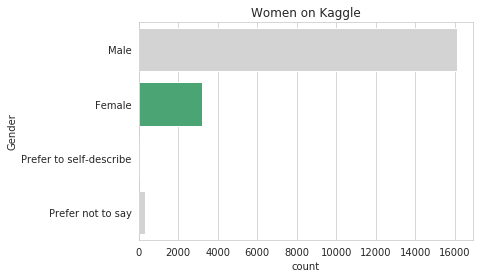

In [3]:
sns.countplot(y='Gender', data=df, palette=[color_back, color_front, color_back, color_back])
plt.title('Women on Kaggle');

# Gender ratio across countries

Let's dive a bit deeper, and plot how number of females compare across different countries. We can see that a majority of them come from India, followed by the USA. It turns out that female kagglers from these countries are a majority of female kagglers from all countries! The order of countries, sorted by number of kagglers is a bit different for male kagglers.

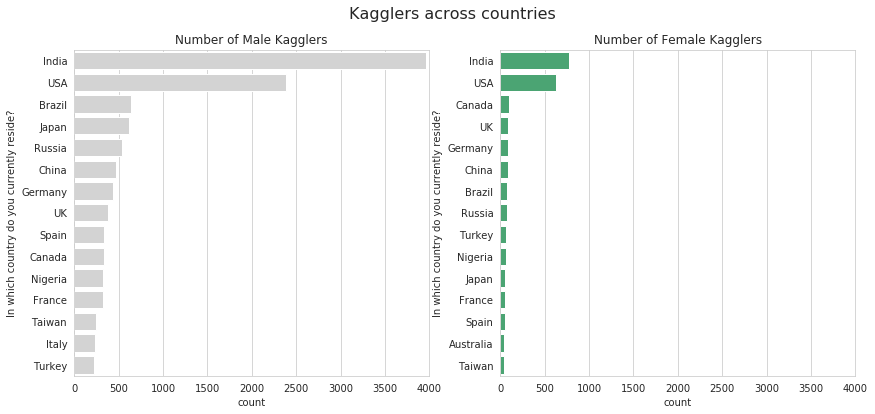

In [4]:
df = df.loc[df['Gender'].isin(['Female', 'Male'])]
df_women_countries = df.loc[df['Gender']=='Female', :]
df_women_countries = df_women_countries.loc[df_women_countries[country_col]!='Other', :]

df_men_countries = df.loc[df['Gender']=='Male', :]
df_men_countries = df_men_countries.loc[df_men_countries[country_col]!='Other', :]

fig = plt.figure(figsize=(14, 6))

ax1 = fig.add_subplot(1, 2, 1)
sns.countplot(y=country_col, 
              data=df_men_countries, 
              order=df_men_countries[country_col].value_counts().iloc[:15].index, 
              color=color_back)
ax1.set_xlim(0, 4000)
ax1.set_title('Number of Male Kagglers');

ax2 = fig.add_subplot(1, 2, 2)
sns.countplot(y=country_col, 
              data=df_women_countries, 
              order=df_women_countries[country_col].value_counts().iloc[:15].index, 
              color=color_front)
ax2.set_xlim(0, 4000)
ax2.set_title('Number of Female Kagglers')
plt.suptitle('Kagglers across countries', fontsize=16);

It might also be very informative, to analize fraction of female kagglers, instead of raw counts. On average, around 17% kagglers are female. This fraction differs, across countries. We can obseve that it might be really tiny. In Tunisia, there is almost equal number of female and male kagglers! Similarly, in Philippines, Iran and Malaysia, there about 30% of female kagglers. Unfortunately, it is due to the fact, that there is very little data about kagglers in this countries.

Average fraction of female kagglers: 0.168


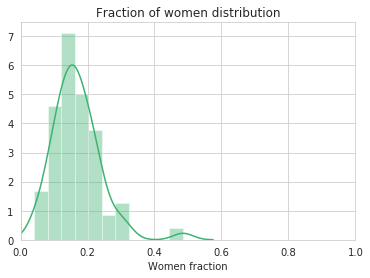

In [5]:
df_country_count = pd.DataFrame(df[country_col].value_counts())
df_country_count.rename(columns={'index': 'Country', country_col: 'Count'}, inplace=True)

df_women_country_count = pd.DataFrame(df.loc[df['Gender']=='Female', country_col].value_counts())
df_women_country_count.rename(columns={'index': 'Country', country_col: 'Women count'}, inplace=True)

df_country_count = df_country_count.join(df_women_country_count)
df_country_count['Women fraction'] = df_country_count['Women count'] / df_country_count['Count']
df_country_count = df_country_count.sort_values(by='Women fraction', ascending=False).reset_index()


sns.distplot(df_country_count['Women fraction'], color=color_front)
plt.xlim(0, 1.0)
plt.title('Fraction of women distribution');
print(f'Average fraction of female kagglers: {round(np.mean(df_country_count["Women fraction"]), 3)}')

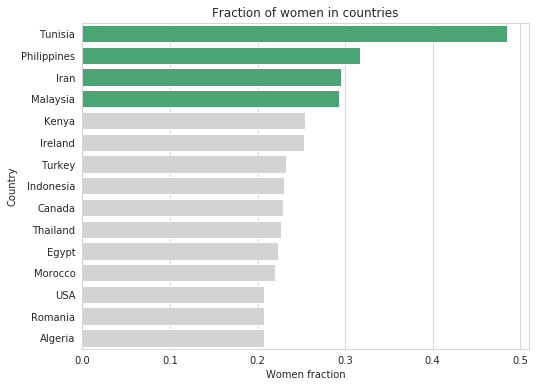

In [6]:
fig = plt.figure(figsize=(8, 6))
sns.barplot(data=df_country_count, 
            x='Women fraction', 
            y='index', 
            order=df_country_count['index'].iloc[:15],
            palette=[color_front for _ in range(4)] + [color_back for _ in range(11)])
plt.ylabel('Country')
plt.title('Fraction of women in countries');

In [7]:
print(f'There is {df_country_count.loc[df_country_count["index"]=="Tunisia", "Count"].values[0]} kagglers in Tunisia')
print(f'There is {df_country_count.loc[df_country_count["index"]=="Philippines", "Count"].values[0]} kagglers in Philippines')
print(f'There is {df_country_count.loc[df_country_count["index"]=="Iran", "Count"].values[0]} kagglers in Iran')
print(f'There is {df_country_count.loc[df_country_count["index"]=="Malaysia", "Count"].values[0]} kagglers in Malaysia')

There is 68 kagglers in Tunisia
There is 60 kagglers in Philippines
There is 95 kagglers in Iran
There is 75 kagglers in Malaysia


# Gender ratio across roles

It's also interesting how a gender ratio differs across groups with different job titles. For the sake of this analysis, I grouped job titles into three categories:
- jobs focused on data science
- jobs more focused on engineering, that is either data or software engineering jobs
- students

We can see that the biggest fraction of females is present among students, followed by data science jobs. In data engineers / software engineers group, there is smallest fraction of women.

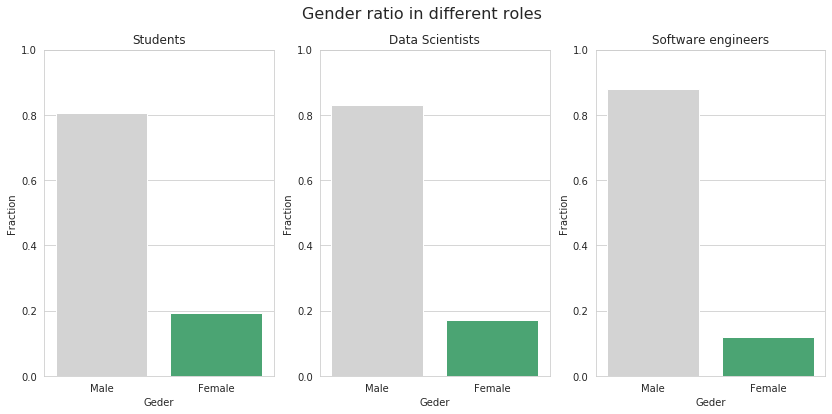

In [8]:
data_science_jobs = ['Data Scientist', 'Data Analyst', 'Research Scientist', 'Statistician']
df_ds_jobs = df.loc[df[job_title_col].isin(data_science_jobs)]
df_students = df.loc[df[job_title_col]=='Student']
se_jobs = ['Data Engineer', 'Software Engineer']
df_se_jobs = df.loc[df[job_title_col].isin(se_jobs)]

fig = plt.figure(figsize=(14, 6))

# Students
ax1 = fig.add_subplot(1, 3, 1)
sns.barplot(x='Gender', 
            y='Gender', 
            data=df_students, 
            estimator=lambda x: len(x) / len(df_students), 
            orient='v', 
            palette=[color_back, color_front, color_back, color_back])
ax1.set_xlabel('Geder')
ax1.set_ylabel('Fraction')
ax1.set_ylim(0.0, 1.0)
ax1.set_title('Students')

# Data Science
ax2 = fig.add_subplot(1, 3, 2)
sns.barplot(x='Gender', 
            y='Gender', 
            data=df_ds_jobs, 
            estimator=lambda x: len(x) / len(df_ds_jobs), 
            orient='v', 
            palette=[color_back, color_front, color_back, color_back])
ax2.set_xlabel('Geder')
ax2.set_ylabel('Fraction')
ax2.set_ylim(0.0, 1.0)
ax2.set_title('Data Scientists');

# Software engineering
ax3 = fig.add_subplot(1, 3, 3)
sns.barplot(x='Gender', 
            y='Gender', 
            data=df_se_jobs, 
            estimator=lambda x: len(x) / len(df_se_jobs), 
            orient='v', 
            palette=[color_back, color_front, color_back, color_back])
ax3.set_xlabel('Geder')
ax3.set_ylabel('Fraction')
ax3.set_ylim(0.0, 1.0)
ax3.set_title('Software engineers')
plt.suptitle('Gender ratio in different roles', fontsize=16);

# Women salaries

Looking at distribution of women salaries, one can see that its range is very wide.

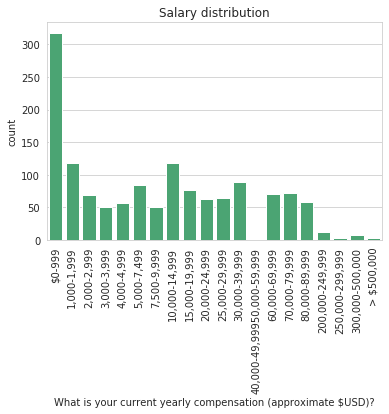

In [9]:
salary_type = CategoricalDtype(categories=["$0-999", "1,000-1,999", "2,000-2,999", "3,000-3,999", "4,000-4,999",
                                           "5,000-7,499", "7,500-9,999", "10,000-14,999", "15,000-19,999",
                                           "20,000-24,999", "25,000-29,999", "30,000-39,999", "40,000-49,999"
                                           "50,000-59,999", "60,000-69,999", "70,000-79,999", "80,000-89,999",
                                           "200,000-249,999", "250,000-299,999", "300,000-500,000", "> $500,000"],
                               ordered=True)
df[salary_column] = df[salary_column].astype(salary_type)
df_women = df.loc[df['Gender']=='Female', :]
sns.countplot(data=df_women, x=salary_column, color=color_front)
plt.xticks(rotation=90)
plt.title('Salary distribution');

# Sociodemographics

Next, we will try to understand general sociodemographic picture of female kagglers. Largest group falls withing 25-29 years age range. People come to Kaggle to learn, what can be seen at experience distribution - the smaller their experience, the more of them is present at the platform. In terms of education, vast majority of women have either Master, Bachelor or phd degree. The most frequent job titles are student and data scientist.

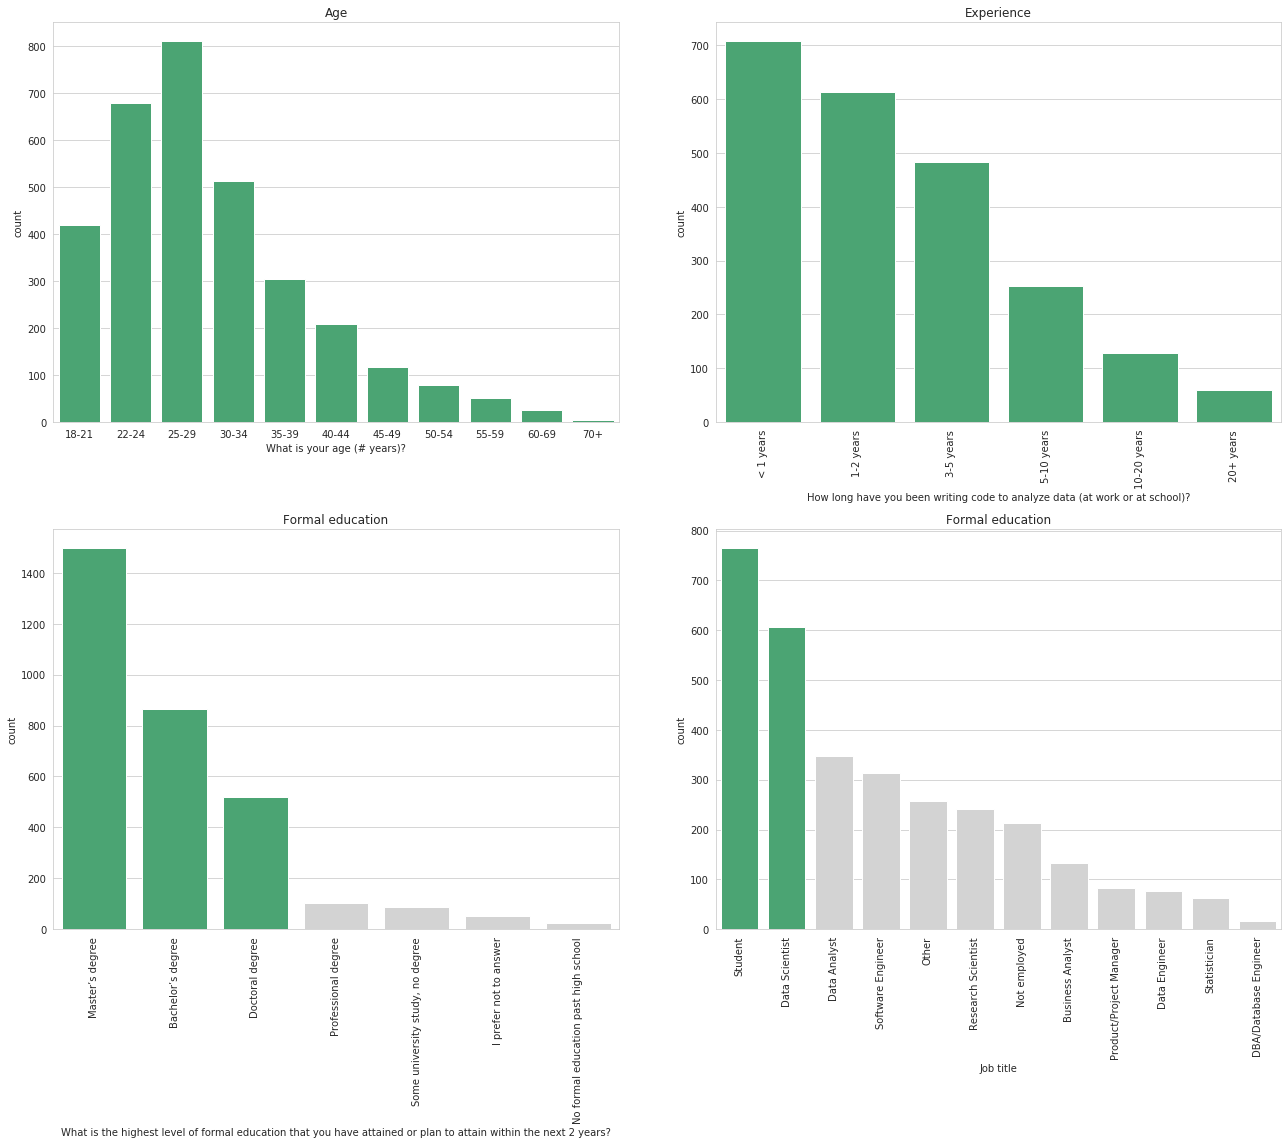

In [10]:
# Age preprocessing
age_type = CategoricalDtype(categories=['18-21', '22-24', '25-29', '30-34', '35-39', '40-44', 
                                        '45-49', '50-54', '55-59', '60-69', '70+'], ordered=True)
df[age_column] = df[age_column].astype(age_type)
# Experience preprocessing
experience_type = CategoricalDtype(categories=['< 1 years', '1-2 years', '3-5 years', '5-10 years', 
                                               '10-20 years', '20+ years'], ordered=True)
df[experience_column] = df[experience_column].astype(experience_type)
# Education preprocessing
df.loc[df[education_column]=='Some college/university study without earning a bachelor’s degree', education_column] = 'Some university study, no degree'

df_women = df.loc[df['Gender']=='Female', :]

fig = plt.figure(figsize=(18, 16))

ax1 = fig.add_subplot(2, 2, 1)
sns.countplot(data=df_women, x=age_column, color=color_front)
ax1.set_title('Age')

ax2 = fig.add_subplot(2, 2, 2)
sns.countplot(data=df_women, x=experience_column, color=color_front)
ax2.set_title('Experience')
plt.xticks(rotation=90)

ax3 = fig.add_subplot(2, 2, 3)
sns.countplot(data=df_women, 
              x=education_column, 
              order=df_women[education_column].value_counts().index,
              palette=[color_front for _ in range(3)] + [color_back for _ in range(6)])
plt.xticks(rotation=90)
ax3.set_ylabel('count')
ax3.set_title('Formal education')

ax4 = fig.add_subplot(2, 2, 4)
sns.countplot(data=df_women, 
              x=job_title_col, 
              order=df_women[job_title_col].value_counts().index,
              palette=[color_front for _ in range(2)] + [color_back for _ in range(10)])
plt.xticks(rotation=90)
ax4.set_ylabel('count')
ax4.set_title('Formal education')

plt.tight_layout();

# Skills

Next, I will take a closer look at skills the survey's participants have, and how can those skills be used to build a biparite users-skills graph. This graph will be then used to extract projected users graph from users partition and projected skills graph from skills partition.

Structure of both of this graphs will be then examined using social network analysis techniques. It is very interesting to learn how a graph structure can be used to visualize such a multidemnsional dataset. Some patterns might be easier to observe using this kind of representation, instead of classical statistical plots.

On average, each user has chosen around 11 skills. Median is a bit smaller: 9 skills. There is around one thousand users that did not choose any skill.

Average number of skills: 10.75
Median number of skills: 9.0
Number of users that did not choose any skill: 1008


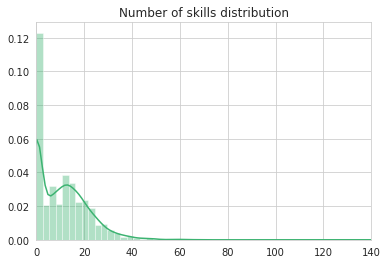

In [11]:
df_skills = pd.read_csv(data_folder + 'processed/skills_data.csv')
df_skills = df_skills.astype(np.int8)

skills_counts = df_skills.sum(axis=1)
print(f'Average number of skills: {round(np.mean(skills_counts), 2)}')
print(f'Median number of skills: {round(np.median(skills_counts), 2)}')
print(f'Number of users that did not choose any skill: {len(np.where(skills_counts==0)[0])}')
sns.distplot(skills_counts, color=color_front)
plt.xlim(0, 140)
plt.title('Number of skills distribution');

In order to build biparitate graph, I filter out users that did not choose any skill. To exclude weak relationships between nodes, I choose a threshold of 10 skills to create a tie. Similarly, I choose a threshold of 100 users to connect a pair of skills.

The color of graph's nodes is their K-Core value. Nodes are scalled acording to their degree. Center of a graph represents very well connected nodes, with almost all nodes connected to all other nodes. It means, that in terms of skills, kagglers are very homogenous group. It also indicates that data scientists tools are pretty standarized. There are also some outliers at the graph's periphery, indicating users with very small number of skills, and as a result, very small degree.

In [12]:
# Discard rare skills
df_skills = df_skills.loc[:, df_skills.sum(axis=0) > 50]
# Discard users that haven't chosen at least n skills
df_skills = df_skills[df_skills.sum(axis=1) > 1]
# Connect users if they have at least n common skills
min_shared_skills_to_connect = 10
# Connect skills if they have at least n common users
min_shared_users_to_connect = 100

# Create biparite user-skill graph
skills_matrix = scipy.sparse.csr_matrix(df_skills.values)
BG = nx.algorithms.bipartite.matrix.from_biadjacency_matrix(skills_matrix)

# Extract projected users graph
partitions = bipartite.sets(BG)
users_partition = partitions[0]
skills_partition = partitions[1]

UG = bipartite.weighted_projected_graph(BG, users_partition)
# Connect only those users who share at least 10 skills
UG_filtered = nx.Graph()
for edge in tqdm.tqdm_notebook(UG.edges(data=True)):  
    u, v, weight = edge
    weight = weight['weight']

    if weight > min_shared_skills_to_connect:
        UG_filtered.add_edge(u, v, weight=weight)
        
del UG

Number of nodes in the female kagglers graph: 1492
Number of edges in the female kagglers graph: 200110


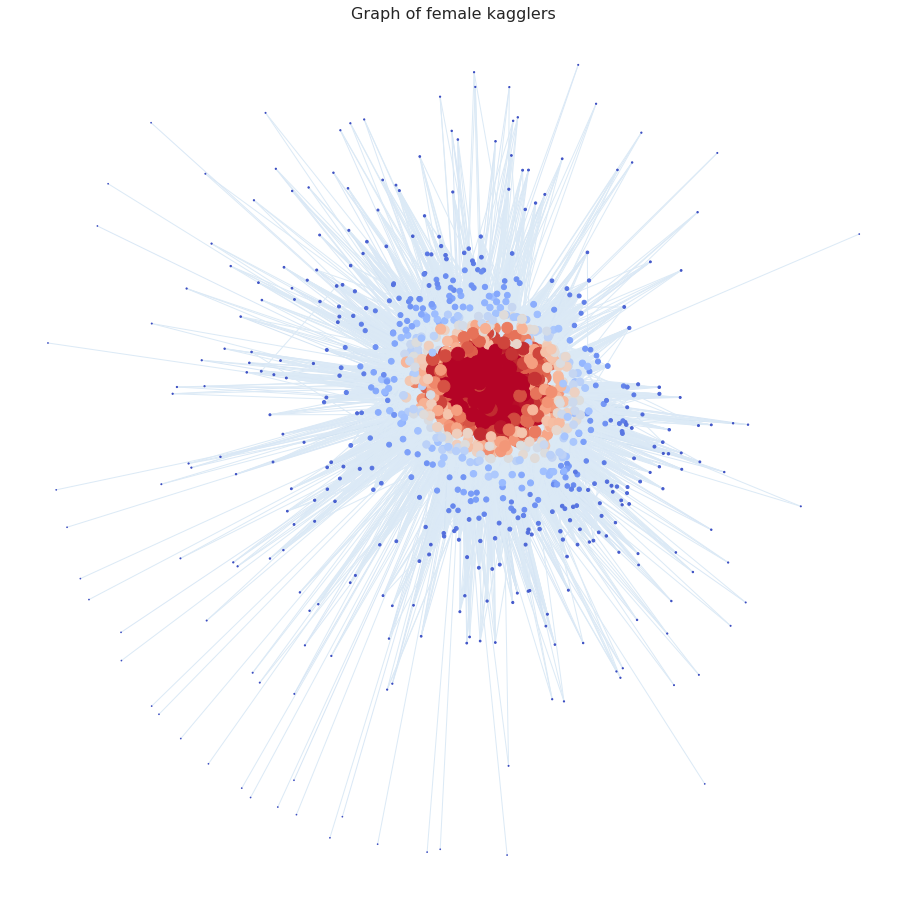

In [13]:
print(f'Number of nodes in the female kagglers graph: {UG_filtered.order()}')
print(f'Number of edges in the female kagglers graph: {UG_filtered.size()}')

plt.figure(figsize=(16, 16))
pos = nx.spring_layout(UG_filtered)
degrees = dict(UG_filtered.degree())
cores_dict = nx.algorithms.core.core_number(UG_filtered)
edge_weight = [attr['weight'] * 10 for u, v, attr in UG_filtered.edges(data=True)]
edge_color = [w * 10 for w in edge_weight]
nx.draw_networkx_nodes(UG_filtered, 
                       pos, 
                       node_color=list(cores_dict.values()),
                       cmap=plt.cm.coolwarm,
                       node_size=[min(0.5 * d, 200) for d in degrees.values()])
nx.draw_networkx_edges(UG_filtered, 
                       pos, 
                       edge_color=edge_color,
                       edge_vmin=0,
                       edge_vmax=max(edge_color),
                       edge_cmap=plt.cm.Blues)
plt.title('Graph of female kagglers', fontsize=16)
plt.axis('off');

Average clustering: 0.805
Average shortest paths: 1.82


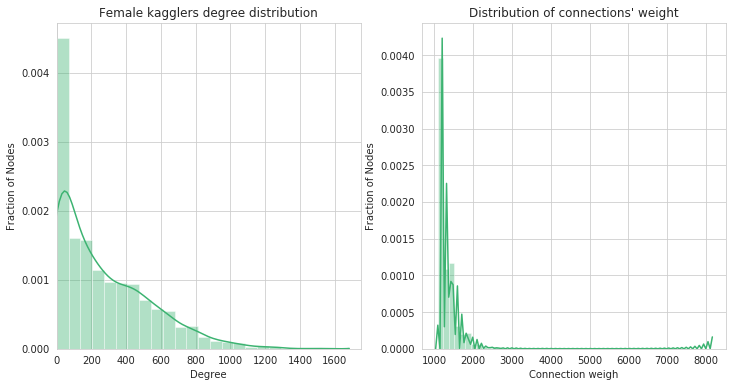

In [14]:
print(f'Average clustering: {round(nx.average_clustering(UG_filtered), 3)}')
print(f'Average shortest paths: {round(nx.average_shortest_path_length(UG_filtered), 3)}')

fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(1, 2, 1)
degrees = list(dict(UG_filtered.degree()).values())
sns.distplot(degrees, norm_hist=True, color=color_front)
ax1.set_xlim(0, 1750)
ax1.set_xlabel('Degree')
ax1.set_ylabel('Fraction of Nodes')
ax1.set_title('Female kagglers degree distribution')

ax2 = fig.add_subplot(1, 2, 2)
sns.distplot(edge_color, color=color_front)
ax2.set_xlabel('Connection weigh')
ax2.set_ylabel('Fraction of Nodes')
ax2.set_title('Distribution of connections\' weight')
plt.show();

This two distributions help us better understand the Kaggle users graph. Degree distribution has an exponential distribution, there is a lot of users with no much skills - these are probably beginners, just starting to explore data science. These are the blue dots. But there is also significant amount of users in the center of the graph, with a very hight degree. These are users that have a similar skilset to other users. It means that Kaggle is really good at standarizing skills that users have. It is widely known that some algorithms like XGBoost got famous when proved to perform really well in the competitions.

In the graph, connection weight indicates a number of skills shared by a pair of connected users. What is interesting, is that some users share a lot of skills.

# Skills graph

Second projected graph describes connections between particular skills that kagglers share.

In [15]:
# Create skills graph, label the nodes with skills name
SG = bipartite.weighted_projected_graph(BG, skills_partition)
for i, name in enumerate(dict(SG.nodes()).keys()):
    SG.nodes[name]['label'] = df_skills.columns[i]

# Fix labels
mapping = {k: v['label'] for k, v in dict(SG.nodes(data=True)).items()}
SG = nx.relabel.relabel_nodes(SG, mapping)

# Filter the skills graph
# Leave the connection only between skills that are shared by at least 100 kagglers
initial_edges = list(SG.edges(data=True))
for edge in tqdm.tqdm_notebook(initial_edges):  
    u, v, weight = edge
    weight = weight['weight']

    if weight < min_shared_users_to_connect:
        SG.remove_edge(u, v)
        
# Leave the skills with a degree at least one
degrees = list(dict(SG.degree()).values())
initial_nodes = list(SG.nodes())
for i, node in tqdm.tqdm_notebook(enumerate(initial_nodes)):
    if degrees[i] < 1:
        SG.remove_node(node)
    

print(f'Number of nodes in the skills graph: {SG.order()}')
print(f'Number of edges in the skills graph: {SG.size()}')


Number of nodes in the skills graph: 68
Number of edges in the skills graph: 793


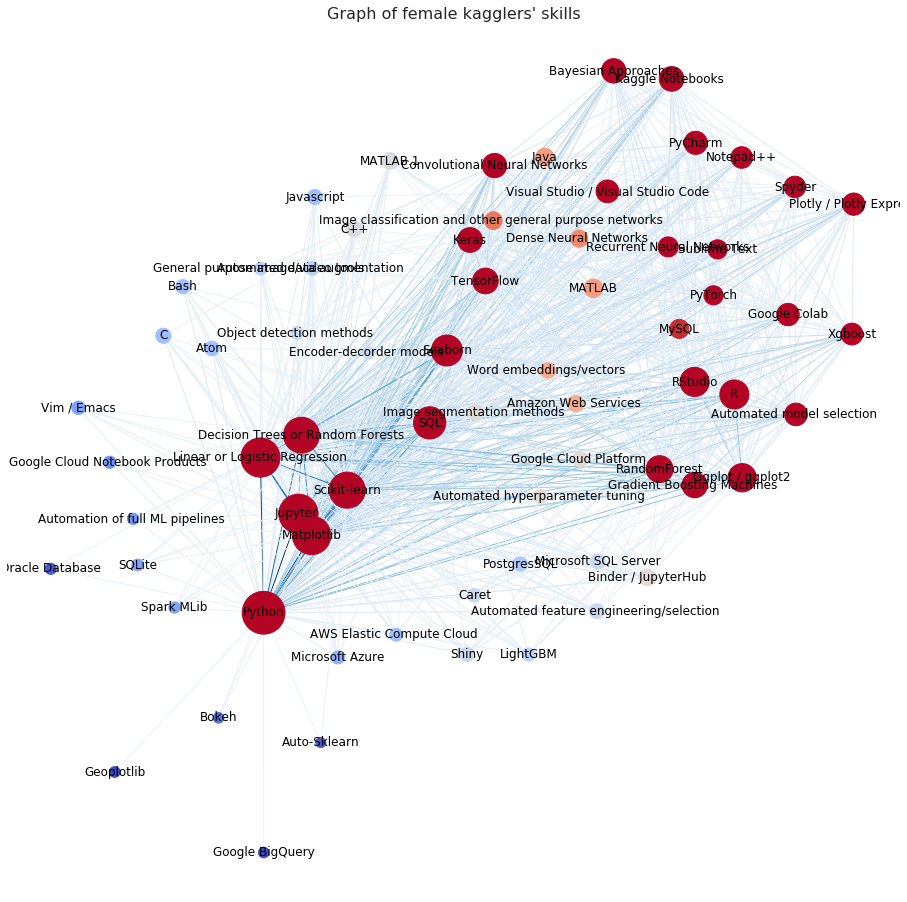

In [16]:
plt.figure(figsize=(16, 16))
pos = nx.kamada_kawai_layout(SG)

# Plot nodes, scalled according to their popularity
df_skill_popularity = pd.DataFrame(df_skills.sum(axis=0), index=df_skills.columns, columns=['count'])
cores_dict = nx.algorithms.core.core_number(SG)
nx.draw_networkx_nodes(SG, 
                       pos, 
                       node_color=list(cores_dict.values()),
                       cmap=plt.cm.coolwarm,
                       node_size=[df_skill_popularity.loc[name, 'count'] for name in SG.nodes()])
# Plot edges
edge_color = [attr['weight'] * 10 for u, v, attr in SG.edges(data=True)]
nx.draw_networkx_edges(SG, 
                       pos, 
                       edge_color=edge_color,
                       edge_vmin=0,
                       edge_vmax=max(edge_color),
                       edge_cmap=plt.cm.Blues)
# Plot labels
nx.draw_networkx_labels(SG, pos, fontsize=8)
plt.title('Graph of female kagglers\' skills', fontsize=16)
plt.axis('off');

Average clustering: 0.84
Average shortest paths: 1.652


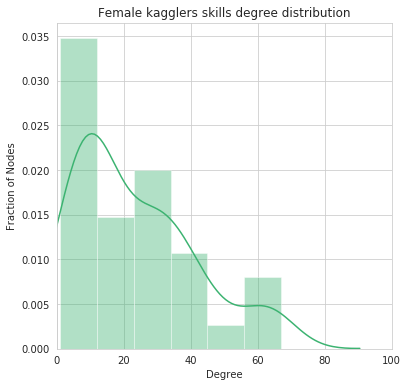

In [17]:
print(f'Average clustering: {round(nx.average_clustering(SG), 3)}')
print(f'Average shortest paths: {round(nx.average_shortest_path_length(SG), 3)}')
figure = plt.figure(figsize=(6, 6))
ax = plt.axes()

degrees = list(dict(SG.degree()).values())
sns.distplot(degrees, norm_hist=True, color=color_front)
plt.xlim(0, 100)
plt.xlabel('Degree')
plt.ylabel('Fraction of Nodes')
plt.title('Female kagglers skills degree distribution')
plt.show();